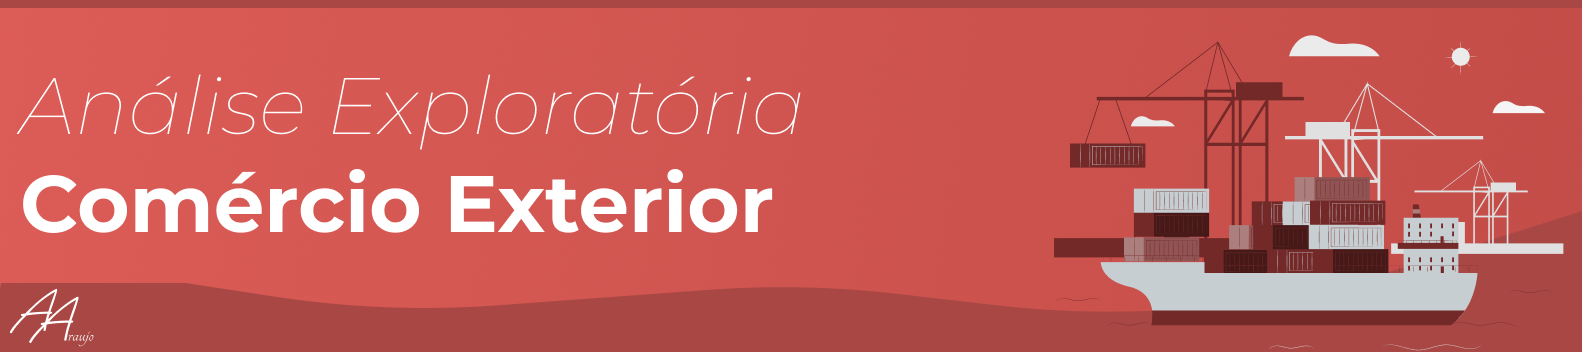

# Exploração de dados Comércio Exterior

<span style="font-size: 14px;">A área de comércio exterior de uma empresa automotiva, busca melhorar o monitoramento dos embarques de importação, implementando uma torre de controle eficiente. A empresa enfrenta desafios críticos, como paralisações na linha de produção devido a atrasos nas entregas, e precisa de uma visão completa das operações logísticas para tomar decisões mais inteligentes, encontrar oportunidades de melhoria e garantir o cumprimento dos prazos, minimizando o impacto em toda a cadeia de suprimentos.</span>

<span style="color: var(--vscode-foreground);">O objetivo desta análise exploratória é responder as perguntas de negócios para posteriormente servir como base para o painel de visualização (Dashboard).</span>

1. <span style="color: var(--vscode-foreground);"><b>Monitoramento de Operações:</b> Acompanhar as operações de importação, separadas por modal aéreo e marítimo;</span>
2. **Indicadores de Entrega:** Avaliar o desempenho de entrega no prazo(On Time Delivery, também conhecido como OTD) para cada modal, comparando com metas pré-estabelecidas;
3. **Desempenho de Operadores:** Avaliar a performance de cada operador logístico (companhias de transporte) envolvidos nas entregas;
4. **Exceções:** Identificar e categorizar desvios e exceções (tipos de problemas) no processo logístico que afetam a entrega pontual;
5. **Quantidade de Embarque:** Número total de embarques realizados, separados por modal;
6. **OTD(_On Time Delivery_):** Percentual de entregas realizadas dentro do prazo para cada modal, comparado com a meta estabelecida;
7. **Ranking de Exceções:** Classificação dos principais tipos de exceções que causam desvio nas operações, como atrasos do fornecedor, avarias, problemas de documentação, etc;
8. **Desempenho por Operador:** Performance dos operadores logísticos(companhias de transporte), considerando a porcentagem de OTD e total de embarques;
9. **Tendência Mensal OTD:** Visualização de tendência mensal para identificar padrões de entregas ao longo do tempo.

<span style="font-size: 14px;"><strong>Créditos da base de dados:</strong> Dados sintéticos disponibilizados no Power Bi Discovery (Karine Lago e Letícia S.)</span>

In [3]:
-- Consultar as tabelas existentes no banco de dados
USE logisticadb;

SELECT TABLE_NAME
FROM INFORMATION_SCHEMA.TABLES
WHERE TABLE_TYPE = 'BASE TABLE';

(3 rows affected)

Total execution time: 00:00:00.024

TABLE_NAME
historico_import
operador
desvio


Relacionamento das tabelas:

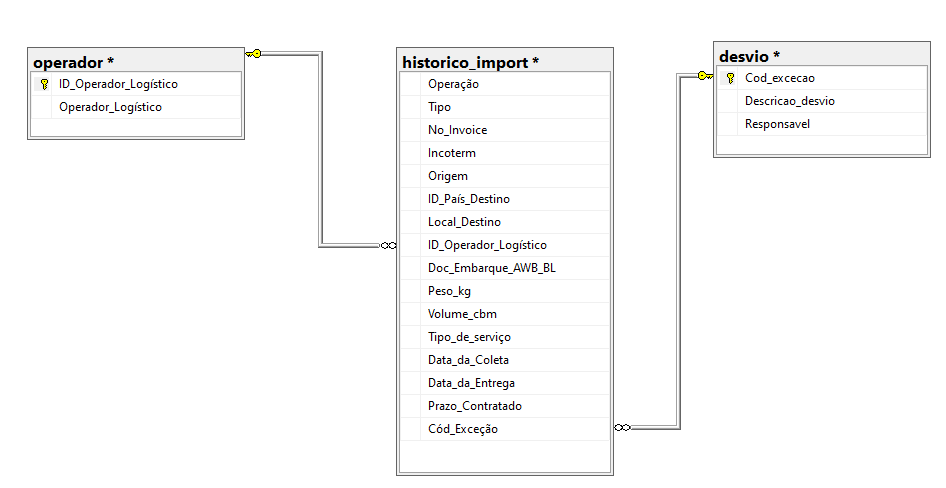

In [10]:
-- Taxa de embarque por modal aéreo e marítimo
SELECT
   Tipo,
   COUNT(*) AS 'Quantidade_embarque',
   FORMAT(1.0 * COUNT(*)/SUM(COUNT(*))OVER(),'0.00%') AS 'Percentual'
FROM logisticadb.dbo.historico_import
GROUP BY Tipo

(2 rows affected)

Total execution time: 00:00:00.309

Tipo,Quantidade_embarque,Percentual
Aéreo,3530,"85,89%"
Marítimo,580,"14,11%"


In [25]:
-- Criando uma coluna de prazo realiado para cálculo do OTD
CREATE OR ALTER VIEW Resumo 
AS(
SELECT
    *,
    DATEDIFF(DAY,Data_da_Coleta,Data_da_Entrega) AS 'Prazo_Realizado',
    IIF(DATEDIFF(DAY,Data_da_Coleta,Data_da_Entrega) <= Prazo_Contratado,'Dentro do prazo','Atraso') AS 'Status_entrega'
FROM logisticadb.dbo.historico_import
)

Commands completed successfully.

Total execution time: 00:00:00.010

In [40]:
-- Cálculo do OTD
WITH x AS(
SELECT
    Tipo,
    COUNT(*) AS 'Qtd_embarque',
    SUM(IIF(Status_entrega = 'Dentro do prazo',1,0)) AS 'On time',
    SUM(IIF(Status_entrega = 'Atraso',1,0)) AS 'Atraso'
FROM Resumo
GROUP BY Tipo
)
SELECT 
    Tipo,
    Qtd_embarque,
    [On time],
    FORMAT(1.0 * [On time]/[Qtd_embarque],'0.00%') AS '%On Time',
    Atraso,
    FORMAT(1.0 * Atraso/[Qtd_embarque],'0.00%') AS '%Atraso'
FROM x

(2 rows affected)

Total execution time: 00:00:00.021

Tipo,Qtd_embarque,On time,%On Time,Atraso,%Atraso
Aéreo,3530,2905,"82,29%",625,"17,71%"
Marítimo,580,416,"71,72%",164,"28,28%"


In [54]:
-- Performance por operador logístico
WITH x AS(
SELECT 
    o.Operador_Logístico,
    COUNT(*) AS 'Qtd_embarque',
    SUM(IIF(Status_entrega = 'Dentro do prazo',1,0)) AS 'On time'
FROM Resumo r
INNER JOIN logisticadb.dbo.operador o ON r.ID_Operador_Logístico = o.ID_Operador_Logístico
GROUP BY o.Operador_Logístico
)
SELECT 
    Operador_Logístico,
    FORMAT(1.0 * [On time]/[Qtd_embarque],'0.00%') AS '%On Time'
FROM x
ORDER BY [%On time] DESC

(5 rows affected)

Total execution time: 00:00:00.017

Operador_Logístico,%On Time
LM Logistics,"89,47%"
Fast Airways,"89,29%"
Lufthanva,"86,50%"
DKL Express,"70,48%"
Next Airlines,"68,08%"


In [61]:
-- Detalhamento de OTD por pais de origem e destino
SELECT
    Origem,
    Local_Destino,
    COUNT(*) AS Total_embarque,
    FORMAT(1.0 * SUM(IIF(Status_entrega = 'Dentro do prazo',1,0))/COUNT(*),'0.00%') AS '%On Time'
FROM Resumo
GROUP BY Origem, Local_Destino
ORDER BY [Total_embarque] DESC

(38 rows affected)

Total execution time: 00:00:00.037

Origem,Local_Destino,Total_embarque,%On Time
DE-Germany,Campinas,1644,"88,50%"
HU-Hungary,Campinas,686,"87,90%"
US-United States,Santos,257,"64,59%"
DE-Germany,Santos,245,"75,10%"
GB-United Kingdom,Campinas,230,"89,13%"
FR-France,Campinas,176,"73,30%"
CH-Switzerland,Campinas,106,"50,94%"
IT-Italy,Campinas,84,"55,95%"
IT-Italy,Sao Paulo,78,"56,41%"
ES-Spain,Sao Paulo,72,"26,39%"


In [91]:
-- Ranking exceção desvio
SELECT 
    d.Descricao_desvio,
    COUNT(*) AS Total,
    FORMAT(1.0 * COUNT(*)/SUM(COUNT(*))OVER(),'0.00%') AS Percentual
FROM logisticadb.dbo.historico_import h
INNER JOIN logisticadb.dbo.desvio d
ON CAST(h.Cód_Exceção AS INTEGER) = RIGHT(d.Cod_excecao,1)
GROUP BY d.Descricao_desvio
ORDER BY Total DESC

(6 rows affected)

Total execution time: 00:00:00.079

Descricao_desvio,Total,Percentual
Atraso Fornecedor,41,"25,00%"
Extravio (Carga Perdida),40,"24,39%"
"Força Maior (clima, greve, feriado)",25,"15,24%"
Atraso no Embarque,25,"15,24%"
Avaria (Carga Danificada),20,"12,20%"
Documentação,13,"7,93%"


In [103]:
-- MoM do total de entregas
WITH x AS(
SELECT
    YEAR(Data_da_Entrega) AS Ano,
    MONTH(Data_da_Entrega) AS Mes,
    COUNT(*) AS Total
FROM logisticadb.dbo.historico_import
GROUP BY YEAR(Data_da_Entrega), MONTH(Data_da_Entrega)
)
SELECT
    *,
    COALESCE(FORMAT(1.0 * (Total - LAG(Total,1)OVER(ORDER BY Ano ASC, Mes ASC))/Total,'0.00%'),'-') AS MoM
FROM x
ORDER BY Ano ASC, Mes ASC

(14 rows affected)

Total execution time: 00:00:00.099

Ano,Mes,Total,MoM
2023,1,354,-
2023,2,244,"-45,08%"
2023,3,775,"68,52%"
2023,4,531,"-45,95%"
2023,5,289,"-83,74%"
2023,6,515,"43,88%"
2023,7,50,"-930,00%"
2023,8,338,"85,21%"
2023,9,463,"27,00%"
2023,10,52,"-790,38%"
